In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import os
from google.colab import drive
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder path in Google Drive
folder_path = "/content/drive/MyDrive/data/all_fcts"  # Replace 'your_folder_name' with the actual folder name

# Initialize DataFrame
location_data = pd.DataFrame(columns=["Place", "Latitude", "Longitude", "Number of Peaks", "Total Energy", "Avg Peak Prominence"])

def extract_place_name(file_path):
    return file_path.split("_")[-3] + " " + file_path.split("_")[-2]

def process_file(file_path):
    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
        first_line = lines[0].strip().split()
        latitude, longitude = float(first_line[-2]), float(first_line[-1])
        place_name = extract_place_name(file_path)
        data = np.loadtxt(lines[2:], usecols=(0, 1))
        time = data[:, 0]
        moment = data[:, 1]
        peaks, _ = find_peaks(moment)
        num_peaks = len(peaks)

        # Compute Total Energy (Area under the curve)
        total_energy = np.trapz(moment, time)

        # Compute Peak Prominences
        prominences = peak_prominences(moment, peaks)[0]
        avg_prominence = np.mean(prominences) if len(prominences) > 0 else 0

        global location_data
        temp_df = pd.DataFrame([[place_name, latitude, longitude, num_peaks, total_energy, avg_prominence]],
                               columns=["Place", "Latitude", "Longitude", "Number of Peaks", "Total Energy", "Avg Peak Prominence"])
        location_data = pd.concat([location_data, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Loop through all files in the specified folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and filename.startswith("fctmoysource"):
        process_file(file_path)

# Save to CSV
location_data.to_csv("earthquake.csv", index=False)
print("✅ Done! All files processed and saved to earthquake_data.csv in the current directory.")

# Download the CSV file
files.download("earthquake.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-b5c4e4e4bb5c>:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  location_data = pd.concat([location_data, temp_df], ignore_index=True)


✅ Done! All files processed and saved to earthquake_data.csv in the current directory.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.express as px

# Load the CSV file
df = pd.read_csv("earthquake.csv")
df.head()

,Place,Latitude,Longitude,Number of Peaks,Total Energy,Avg Peak Prominence
0,REGION,-5.987,148.232,7,1.264794e+19,2.008113e+17
1,REGION,-5.451,151.546,2,1.394555e+18,1.972964e+17
2,FIJI ISLANDS,-19.690,-177.759,3,6.073100e+19,5.474418e+18
3,OF CENTRAL,-36.116,-73.517,4,2.384587e+18,1.590431e+17
4,PROVINCE,-32.718,-67.123,5,3.452851e+18,4.768068e+17


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Extract relevant features
X = df.iloc[:, 1:6].values  # Latitude, Longitude, Number of Peaks,Total Energy,Avg Peak Prominence

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

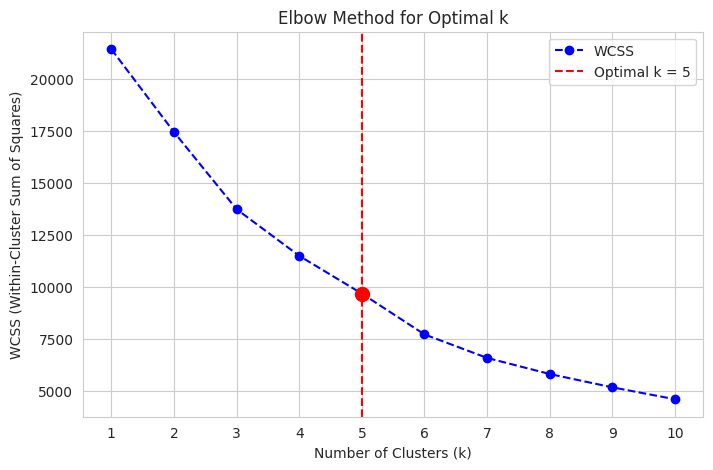

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming X is the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize the data

wcss = []  # List to store WCSS values
K_range = range(1, 11)  # Checking k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is WCSS

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
plt.plot(K_range, wcss, marker='o', linestyle='--', color='b', label="WCSS")

# Annotate the elbow point (Optional: Choose k automatically)
optimal_k = np.diff(wcss, 2).argmin() + 2  # Second derivative heuristic
plt.axvline(x=optimal_k, linestyle="--", color="red", label=f"Optimal k = {optimal_k}")
plt.scatter(optimal_k, wcss[optimal_k - 1], color="red", s=100, zorder=3)

plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.signal import argrelextrema

# Assuming 'wcss' is computed from the elbow method
delta = np.diff(wcss)  # First derivative
delta2 = np.diff(delta)  # Second derivative

# Find local minima in the second derivative (elbow point)
elbow_index = argrelextrema(delta2, np.less)[0]

if len(elbow_index) > 0:
    optimal_k = elbow_index[0] + 2  # Adjust for diff() reducing size
    print(f"Optimal k (Elbow Point): {optimal_k}")
else:
    print("No clear elbow point found.")


Optimal k (Elbow Point): 5


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ensure X is standardized
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # If not already standardized

# Ensure optimal_k is valid
if optimal_k is None or optimal_k < 2:
    print(" Warning: No valid elbow point found or k < 2. Cannot apply K-Means clustering.")
else:
    # Apply K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Compute Silhouette Score
    sil_score = silhouette_score(X_scaled, df['Cluster'])

    print(f" K-Means applied with k={optimal_k}")
    print(f" Silhouette Score: {sil_score:.4f}")


 K-Means applied with k=5
 Silhouette Score: 0.3320


In [ ]:
import plotly.express as px

# Convert 'Cluster' to a string for discrete coloring
df['Cluster'] = df['Cluster'].astype(str)

# Create scatter plot on world map
fig = px.scatter_geo(df,
                     lat='Latitude',
                     lon='Longitude',
                     color='Cluster',
                     hover_name='Place',  # Show place name on hover
                     hover_data={'Latitude': False, 'Longitude': False,
                                 'Total Energy': True, 'Avg Peak Prominence': True,
                                 'Number of Peaks': True},
                     projection="natural earth",
                     title='Earthquake Clusters on World Map (Based on Total Energy & Peak Prominence & number of peaks)',
                     opacity=0.8)  # Slight transparency for better visibility

# Show the interactive map
fig.show()


In [ ]:
# prompt: give code for gmm and also plot on world map.

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)  # Use the optimal k from KMeans
df['GMM_Cluster'] = gmm.fit_predict(X_scaled)

# Silhouette Score for GMM
sil_score_gmm = silhouette_score(X_scaled, df['GMM_Cluster'])
print(f"Silhouette Score (GMM): {sil_score_gmm}")

# Plot GMM clusters on world map
fig_gmm = px.scatter_geo(df, lat='Latitude', lon='Longitude', color='GMM_Cluster',
                        hover_name='Place',
                        projection="natural earth",
                        title='Earthquake Clusters (GMM) on World Map')
fig_gmm.show()


Silhouette Score (GMM): 0.02157757004648013


In [ ]:
# prompt: give code to find optimal epsilon for dbscan

import numpy as np

# DBSCAN
eps_values = np.arange(0.1, 1.0, 0.1)  # Range of epsilon values to test
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)  # Adjust min_samples as needed
    df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
    labels = df['DBSCAN_Cluster']

    # Calculate Silhouette Score only if there's more than one cluster
    if len(set(labels)) > 1 and -1 not in labels: # ignore noise points
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
    else:
      silhouette_scores.append(0)

optimal_eps = eps_values[np.argmax(silhouette_scores)]
print(f"Optimal epsilon: {optimal_eps}")

# Apply DBSCAN with optimal epsilon
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=5)
df['DBSCAN_Cluster'] = dbscan_optimal.fit_predict(X_scaled)

# Plot DBSCAN clusters on the world map
fig_dbscan = px.scatter_geo(df, lat='Latitude', lon='Longitude', color='DBSCAN_Cluster',
                            hover_name='Place',
                            projection="natural earth",
                            title='Earthquake Clusters (DBSCAN) on World Map')
fig_dbscan.show()


Optimal epsilon: 0.9
